In [12]:
import tifffile
import h5py
import numpy as np
import os
from skimage.measure import label
from yacs.config import CfgNode as CN 
import subprocess
from matplotlib import pyplot as plt

In [13]:
_C = CN()

_C.ROOT_GT = "/n/pfister_lab2/Lab/zudilin/data/NucExM/NucExM-Release"
_C.ROOT_PD ="/n/pfister_lab2/Lab/zudilin/data/NucExM/prediction/"
#_C.ROOT_PD ="/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/stardist_output/image0_start_dist_label.tif"
_C.TARGET_DIR = "/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output"

_C.GT = ["seg_3D_255_512_512.h5"]
_C.PD = ["segm_image0_bcd_cysgan_feb23.h5"]
#_C.PD = ["image0_start_dist_label.tif", "image1_start_dist_label.tif", "image2_start_dist_label.tif", "image3_start_dist_label.tif"]


_C.H5KEY = 'main'

In [14]:
def get_cfg_defaults():
    return _C.clone()

cfg = get_cfg_defaults()

In [15]:
def tif_to_h5(orig_path, dest_path, insta=False):
    """ Takes a tiff file and converts it to a h5 file.
        
        Args:
            orig_path: Path to the tiff file
            dest_path: Path where to save the h5 file
    """
    with tifffile.TiffFile(orig_path) as tif, \
            h5py.File(os.path.join(dest_path, orig_path.split("/")[-1].split(".")[0]+".h5"), "w") as h5:
        tif_images = np.asarray([t.asarray() for t in tif.pages[:]])
        if insta:
            tif_images_inst = skimage.measure.label(tif_images)
            assert(tif_images_inst.shape == tif_images.shape)
            h5_dataset =  h5.create_dataset("main", data=tif_images_inst)
        else:
            h5_dataset =  h5.create_dataset("main", data=tif_images)

In [25]:
def h5_seg_to_instance(orig_path, dest_path, insta=True):
    """ Loads a h5 segmantic segmentation datasets and converts it to a 
        instance segmentation dataset by assinging an indivual label to each object.
        
        Args:
            orig_path: Path to the tiff file
            dest_path: Path where to save the h5 file
    """
    with h5py.File(orig_path, 'r') as h5_read, \
            h5py.File(os.path.join(dest_path, orig_path.split("/")[-1]), "w") as h5_write:
        h5_img = np.squeeze(h5_read.get(list(h5_read.keys())[0]))
        if len(h5_img.shape) == 4:
            h5_img = h5_img[0,:,:,:]
        h5_img_inst = label(h5_img)
        assert(h5_img_inst.shape == h5_img.shape)
        h5_dataset =  h5_write.create_dataset("main", data=h5_img_inst)

In [182]:
for i, (gt, pd) in enumerate(zip(cfg.GT, cfg.PD)):
    # convert sematic segmentation masks to instance segmentation maks
    #h5_seg_to_instance(os.path.join(cfg.ROOT_PD, pd), cfg.TARGET_DIR)
    pd_path = os.path.join(cfg.TARGET_DIR, pd)
    gt_path = os.path.join(cfg.TARGET_DIR, gt)
    out_name = pd.split(".")[0]
    cmd = f"python ../mAP_3Dvolume/demo.py -gt {gt_path} -p {pd_path} -o {out_name}"
    print(cmd)
    #subprocess.Popen(cmd, shell=True)

python ../mAP_3Dvolume/demo.py -gt /n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output/seg_3D_255_512_512.h5 -p /n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output/segm_image0_bcd_cysgan_feb23.h5 -o segm_image0_bcd_cysgan_feb23


In [183]:
!python ../mAP_3Dvolume/demo.py -gt /n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output/seg_3D_255_512_512.h5 -p /n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output/segm_image0_bcd_cysgan_feb23.h5 -o segm_image0_bcd_cysgan_feb23


	1. Load data
	2. Compute IoU
	 compute bounding boxes
100%|████████████████████████████████████████| 242/242 [00:01<00:00, 223.18it/s]
	 compute iou matching
10050it [00:14, 687.11it/s]
	-RUNTIME:	32.729 [sec]

start evaluation
Accumulating evaluation results...
DONE (t=0.10s).


In [167]:
tif_to_h5("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif", 
         "/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output")

In [26]:
h5_seg_to_instance("/n/pfister_lab2/Lab/leander/em2exm/slurm_jobs/seg___volume_small__from__dens_van_20E_15DE__train_segmodel/segment/dorsal_b_full_resized/result.h5","/n/pfister_lab2/Lab/leander/cerberus/img_toolbox/mAP_3Dvolume_output")

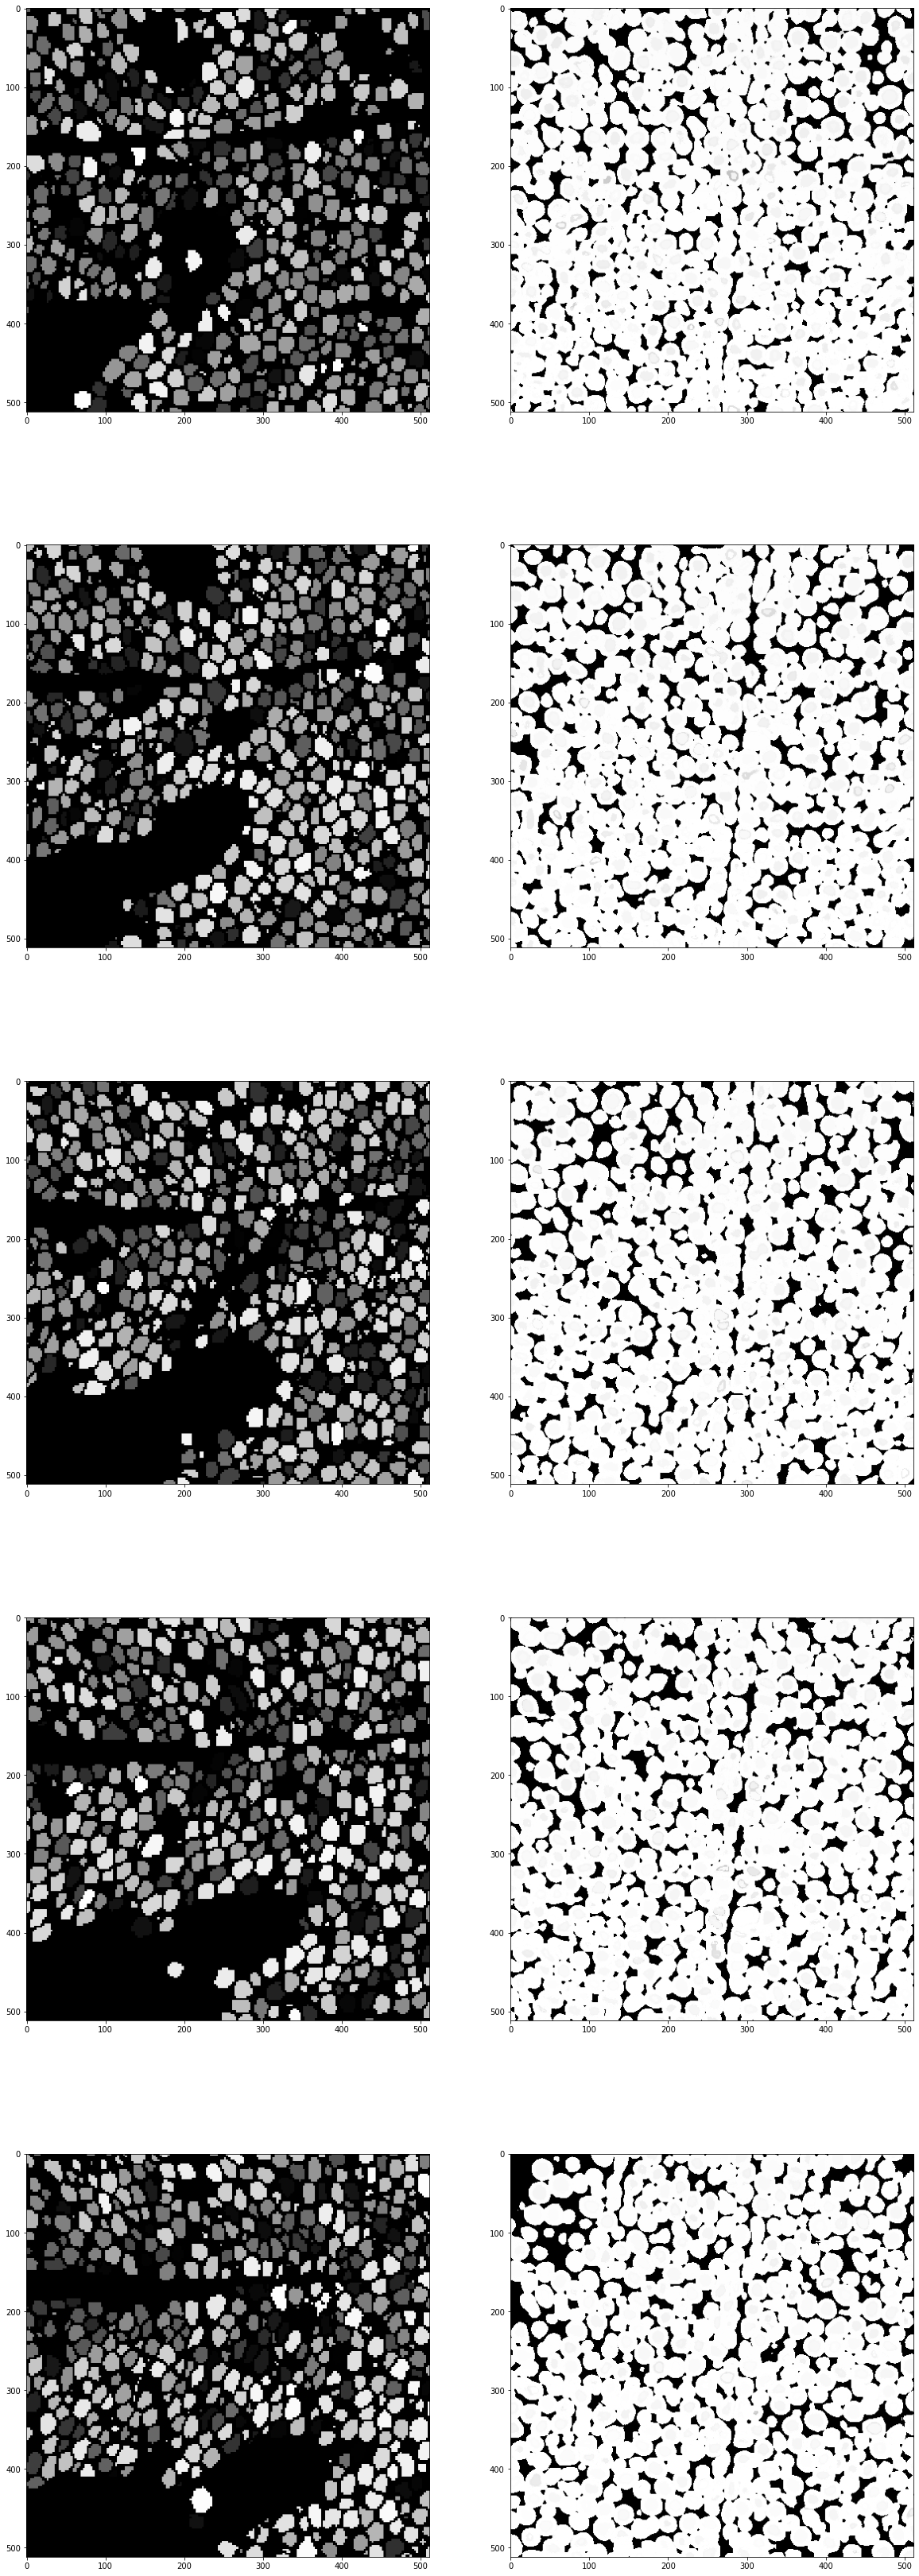

In [28]:
prediction = h5py.File(os.path.join(cfg.TARGET_DIR, cfg.PD[0]), 'r')
groundtruth = h5py.File(os.path.join(cfg.TARGET_DIR, cfg.GT[0]), 'r')
pd = prediction.get(list(prediction.keys())[0])
gt = groundtruth.get(list(label.keys())[0])
                        
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20,60))
axes = axes.flatten()
plt.set_cmap('gray')
for i in range(0, len(axes.flatten())//2):
    axes[2*i+1].imshow(pd[i*10+100])
    axes[(2)*i].imshow(gt[i*10+100])

prediction.close()
groundtruth.close()